In [7]:
from PyCh import *
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('nbagg')

In [14]:
class LiveStepPlot:
    def __init__(self, live = True):
        self.x_data, self.y_data = [], []
        self.figure = plt.figure()
        self.line, = plt.step(self.x_data, self.y_data)
        self.live = live # denotes if the step plot should be updated live

    def update(self, x_data, y_data):
        self.x_data.append( x_data)
        self.y_data.append( y_data)
        self.line.set_data(self.x_data, self.y_data)
        self.figure.gca().relim()
        self.figure.gca().autoscale_view()
        if self.live:
            self.figure.canvas.draw()
        return self.line,

    def show(self):
        plt.show()

<IPython.core.display.Javascript object>


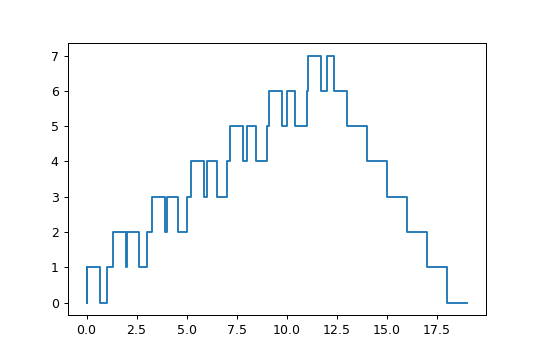

In [17]:
@process
def Generator(env, a):
    for x in range(20):
        yield env.execute(a.send(x))
        yield env.timeout(0.65)

@process
def Buffer(env, a, b): 
    xs = [];
    buffer_plot = LiveStepPlot(live=True)
    while True:
        buffer_plot.update(env.now, len(xs))
       
        receiving = a.receive()
        guard_sending = len(xs)>0                             # The guard function for the sending event
        sending = b.send(xs[0]) if guard_sending else None    # If the guard is not satisfied, sending is defines as None
        x = yield env.select(receiving, sending)
        if selected(receiving):
            xs = xs + [x]
        if selected(sending):
            xs = xs[1:]
                
        
@process
def Server(env, a, b):
    while True:
        x = yield env.execute(a.receive())
        yield env.timeout(1)
        yield env.execute(b.send(x))

@process
def Exit(env, b):
    while True:
        x = yield env.execute(b.receive())
               
def model():
    env = Environment()
    a = Channel(env)
    b = Channel(env)
    c = Channel(env)
    G = Generator(env, a)
    B = Buffer(env, a, b)
    S = Server(env, b, c)
    E = Exit(env, c)
    env.run()
    

model()